# Constrained Local Models - Basics
The aim of this notebook is to showcase how one can build and fit CLMs to images using ``menpofit``.

Note that this notebook assumes that the user has previously gone through the AAMs Basics notebook and he/she is already familiar with the basics of `Menpo`'s Deformable Model Fitting framework explained in there.

## 1. Loading data

In [1]:
%matplotlib inline
from pathlib import Path


path_to_lfpw = Path('/vol/atlas/databases/lfpw')

In [2]:
import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw / 'trainset', verbose=True):
    # crop image
    i = i.crop_to_landmarks_proportion(0.1)
    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

Found 811 assets, index the returned LazyList to import.


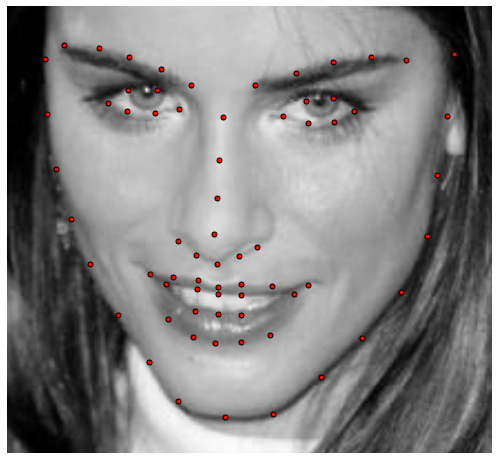

In [3]:
from menpowidgets import visualize_images

visualize_images(training_images)

## 2. Build a CLM with default parameters

Building a CLM using `Menpo` can be done using a single line of code.

In [4]:
from menpofit.clm import CLM


clm = CLM(
    training_images, 
    verbose=True,
    group='PTS',
    diagonal=200
)

- Computing reference shape                                                     Computing batch 0
- Training models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [5]:
print(clm)

Constrained Local Model
 - Images scaled to diagonal: 200.00
 - Scales: [0.5, 1]
   - Scale 0.5
     - Holistic feature: no_op
     - Ensemble of experts class: CorrelationFilterExpertEnsemble
       - 68 experts
       - IncrementalCorrelationFilterThinWrapper class
       - Patch shape: 17 x 17
       - Patch normalisation: no_op
       - Context shape: 34 x 34
       - Cosine mask: True
     - Shape model class: OrthoPDM
       - 132 shape components
       - 4 similarity transform parameters
   - Scale 1
     - Holistic feature: no_op
     - Ensemble of experts class: CorrelationFilterExpertEnsemble
       - 68 experts
       - IncrementalCorrelationFilterThinWrapper class
       - Patch shape: 17 x 17
       - Patch normalisation: no_op
       - Context shape: 34 x 34
       - Cosine mask: True
     - Shape model class: OrthoPDM
       - 132 shape components
       - 4 similarity transform parameters



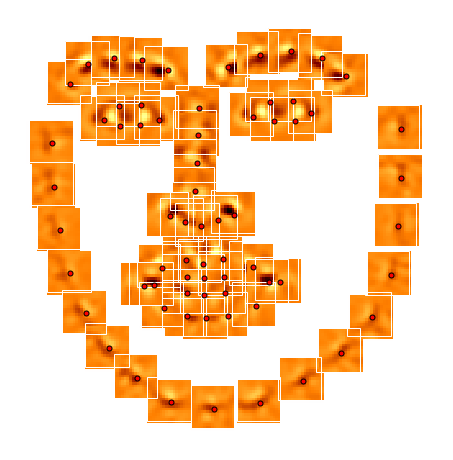

In [6]:
clm.view_clm_widget()

## 3. Fit the previous CLM

In `Menpo`, CLMs can be fitted to images by creating `Fitter` objects around them. 

One of the most popular algorithms for fitting CLMs is the `Regularized Landmark Mean-Shift` algorithm. In order to fit our CLM using this algorithm using `Menpo`, the user needs to define a `GradientDescentCLMFitter` object. This can be done again using a single line of code!!!

In [7]:
from menpofit.clm import GradientDescentCLMFitter

fitter = GradientDescentCLMFitter(clm, n_shape=[6, 12])

Fitting a `GradientDescentCLMFitter` to an image is as simple as calling its `fit` method. Let's try it by fitting some images of the LFPW database test set!!!

In [8]:
import menpo.io as mio

# load test images
test_images = []
for i in mio.import_images(path_to_lfpw / 'testset', max_images=5, verbose=True):
    # crop image
    i = i.crop_to_landmarks_proportion(0.5)
    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    test_images.append(i)

Found 5 assets, index the returned LazyList to import.


Note that for the purpose of this simple fitting demonstration we will just fit the first 5 images of the LFPW test set.

In [9]:
from menpofit.fitter import noisy_shape_from_bounding_box

fitting_results = []

for i in test_images:
    gt_s = i.landmarks['PTS'].lms
    # generate perturbed landmarks
    s = noisy_shape_from_bounding_box(gt_s, gt_s.bounding_box())
    # fit image
    fr = fitter.fit_from_shape(i, s, gt_shape=gt_s) 
    fitting_results.append(fr)

    # print fitting error
    print(fr)

Fitting result of 68 landmark points.
Initial error: 0.0610
Final error: 0.0534
Fitting result of 68 landmark points.
Initial error: 0.0490
Final error: 0.0398
Fitting result of 68 landmark points.
Initial error: 0.0541
Final error: 0.0514
Fitting result of 68 landmark points.
Initial error: 0.0627
Final error: 0.0431
Fitting result of 68 landmark points.
Initial error: 0.0648
Final error: 0.0635


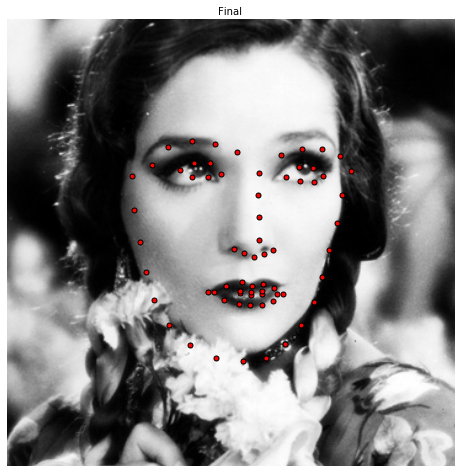

In [10]:
from menpowidgets import visualize_fitting_result

visualize_fitting_result(fitting_results)